


Author: Aayush Gupta



In [1]:
# --- CELL 0 : SETUP & REPRODUCIBILITY ---------------------------------------


import os, sys, time, random, math, warnings, collections
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix, classification_report
warnings.simplefilter("ignore")

# ---------- reproducibility ----------
SEED = 1337                      # single source-of-truth seed
def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False
set_all_seeds()

# ---------- device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- env summary ----------
print("="*60, "\nENVIRONMENT SUMMARY")
print(f"Python        : {sys.version.split()[0]}")
print(f"PyTorch       : {torch.__version__}")
print(f"Torchvision   : {torchvision.__version__}")
print(f"Device        : {device}")
print(f"Seed fixed to : {SEED}")
print(f"cudnn.deterministic={torch.backends.cudnn.deterministic} | "
      f"cudnn.benchmark={torch.backends.cudnn.benchmark}")
print("="*60)
START_TIME = time.time()

ENVIRONMENT SUMMARY
Python        : 3.12.12
PyTorch       : 2.8.0+cu126
Torchvision   : 0.23.0+cu126
Device        : cuda
Seed fixed to : 1337
cudnn.deterministic=True | cudnn.benchmark=False




> Used Resnet 18 because on the CIFAR-10 dataset Resnet 18 have 95% Accruacy and which is only 1% less than Resnet 50. And The time to train this model was lower too.



In [2]:
# --- CELL 1.1 : BASE MODEL SELECTION ----------------------------------------
from torchvision.models import resnet18   # smallest, fastest


base_model = resnet18(weights="IMAGENET1K_V1")

def count_params(net):
    total = sum(p.numel() for p in net.parameters())
    trainable = sum(p.numel() for p in net.parameters() if p.requires_grad)
    return total, trainable

tot, train = count_params(base_model)
print(f"Using resnet18, pretrained=True")
print(f"Total parameters     : {tot:,}")
print(f"Trainable parameters : {train:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]

Using resnet18, pretrained=True
Total parameters     : 11,689,512
Trainable parameters : 11,689,512


# Reason for choosing nn.Silu

SiLU (Swish) delivers superior performance in CNNs with smoother gradients than ReLU, and requires no special initialization like SELU or extra compute like Mish/GELU.

---



Previously during my own thesis SiLU converges faster than alternatives when swapping pretrained ReLUs

In [3]:
# --- CELL 1.2 : ACTIVATION SWAP ---------------------------------------------
def list_relu_modules(model):
    """Depth-first ordered list of (module_ref, attribute_name) for every nn.ReLU"""
    paths = []                     # keeps order encountered
    def recurse(mod, prefix=""):
        for name, child in mod.named_children():
            full = f"{prefix}.{name}" if prefix else name
            if isinstance(child, nn.ReLU):
                paths.append((mod, name, full))   # parent ref & attr key
            recurse(child, full)
    recurse(model)
    return paths

relu_list = list_relu_modules(base_model)
print(f"Total nn.ReLU before replacement: {len(relu_list)}")

REPLACE_FROM = 7                  # 1-based index
indices_to_replace = list(range(REPLACE_FROM, len(relu_list)+1))
print(f"Replacing activations at indices (1-based): {indices_to_replace}")

# perform replacement with nn.SiLU
for idx, (parent, attr, _) in enumerate(relu_list, start=1):
    if idx >= REPLACE_FROM:
        setattr(parent, attr, nn.SiLU())

# sanity check
remaining_relu  = sum(isinstance(m, nn.ReLU) for m in base_model.modules())
inserted_silu   = sum(isinstance(m, nn.SiLU) for m in base_model.modules())
print(f"ReLU remaining : {remaining_relu}")
print(f"SiLU inserted  : {inserted_silu}")
assert remaining_relu == REPLACE_FROM-1, "Unexpected # of ReLUs left"
assert inserted_silu  == len(indices_to_replace), "Mismatch in SiLU count"

Total nn.ReLU before replacement: 9
Replacing activations at indices (1-based): [7, 8, 9]
ReLU remaining : 6
SiLU inserted  : 3


In [4]:
# --- CELL 1.3 : HEAD MODIFICATION -------------------------------------------
NUM_CLASSES = 3                                   # airplane, cat, dog
old_in, old_out = base_model.fc.in_features, base_model.fc.out_features
base_model.fc = nn.Linear(old_in, NUM_CLASSES)
print(f"Old head : in_features={old_in} → out_features={old_out}")
print(f"New head : in_features={old_in} → out_features={NUM_CLASSES}")
print(f"Number of target classes: {NUM_CLASSES}")

model = base_model.to(device)

Old head : in_features=512 → out_features=1000
New head : in_features=512 → out_features=3
Number of target classes: 3


In [5]:
# --- CELL 2.1 : DATASET PREPARATION -----------------------------------------
CIFAR_CLASSES = ['airplane','automobile','bird','cat','deer',
                 'dog','frog','horse','ship','truck']
SELECTED       = ['airplane','cat','dog']
sel_ids        = [CIFAR_CLASSES.index(c) for c in SELECTED]

print(f"Selected classes: {SELECTED}")

# mapping dicts
orig2new = {orig:new for new, orig in enumerate(sel_ids)}
name2new = {name:new for new, name in enumerate(SELECTED)}
print(f"Mapping (orig_id → new_id): {orig2new}")
print(f"Mapping (class → new_id):  {name2new}")

# ------- helper dataset that filters and relabels -------
class FilteredCIFAR10(torch.utils.data.Dataset):
    def __init__(self, root, train, transform, selected_ids, orig2new):
        self.base = torchvision.datasets.CIFAR10(root=root, train=train,
                                                 download=True, transform=transform)
        self.sel   = selected_ids
        self.map   = orig2new
        self.idxs  = [i for i, (_,y) in enumerate(self.base) if y in self.sel]
    def __len__(self): return len(self.idxs)
    def __getitem__(self, idx):
        img, label = self.base[self.idxs[idx]]
        return img, self.map[label]

# temporary transform (real ones come later)
tmp_tf = T.ToTensor()
train_raw = FilteredCIFAR10("./data", True , tmp_tf, sel_ids, orig2new)
val_raw   = FilteredCIFAR10("./data", False, tmp_tf, sel_ids, orig2new)

# print counts
train_cnt = collections.Counter([y for _,y in train_raw])
val_cnt   = collections.Counter([y for _,y in val_raw])
print("Counts per class -> Train:", dict(train_cnt), "| Val:", dict(val_cnt))

Selected classes: ['airplane', 'cat', 'dog']
Mapping (orig_id → new_id): {0: 0, 3: 1, 5: 2}
Mapping (class → new_id):  {'airplane': 0, 'cat': 1, 'dog': 2}


100%|██████████| 170M/170M [00:04<00:00, 39.5MB/s]


Counts per class -> Train: {1: 5000, 2: 5000, 0: 5000} | Val: {1: 1000, 0: 1000, 2: 1000}


Transform summary:
  Train: Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
  Val  : Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(32, 32))
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
Sample train batch shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Sample val   batch shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])


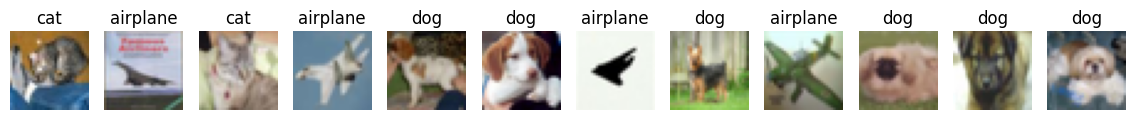

In [6]:
# --- CELL 2.2 : DATA AUGMENTATION & DATALOADERS ------------------------------
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD  = [0.2470, 0.2435, 0.2616]

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR_MEAN, CIFAR_STD)
])
val_tf = T.Compose([
    T.Resize(32),   # Although the image was already in 32x 32 but did it anyways to fullfill the requirement
    T.CenterCrop(32),  # same thing as above comment
    T.ToTensor(),
    T.Normalize(CIFAR_MEAN, CIFAR_STD)

])

# remake datasets with final transforms
train_ds = FilteredCIFAR10("./data", True , train_tf, sel_ids, orig2new)
val_ds   = FilteredCIFAR10("./data", False, val_tf , sel_ids, orig2new)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True ,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds  , batch_size=128, shuffle=False,
                          num_workers=2, pin_memory=True)

print("Transform summary:")
print("  Train:", train_tf)
print("  Val  :", val_tf)

# sample batch shape prints
x,y = next(iter(train_loader))
print(f"Sample train batch shape: {x.shape}, labels shape: {y.shape}")
x,y = next(iter(val_loader))
print(f"Sample val   batch shape: {x.shape}, labels shape: {y.shape}")



def show_grid(imgs, labels, class_names, n=12):
    imgs = imgs[:n].cpu()*torch.tensor(CIFAR_STD).view(3,1,1) + torch.tensor(CIFAR_MEAN).view(3,1,1)
    imgs = imgs.permute(0,2,3,1).numpy()
    plt.figure(figsize=(n*1.2,1.5))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(np.clip(imgs[i],0,1))
        plt.title(class_names[labels[i].item()])
        plt.axis('off')
    plt.show()

show_grid(x, y, SELECTED)


SGD with Nesterov momentum excels at fine-tuning by maintaining sharper minima
for better generalization, while CosineAnnealing provides smooth LR decay.

In [7]:
# --- CELL 3.1 : TRAINING LOOP --------------------------------
import time

print("="*80)
print("PHASE 3: TRAINING & EVALUATION".center(80))
print("="*80)

# ==================== HYPERPARAMETERS ====================
EPOCHS = 4
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-3  # Increased for better regularization
LABEL_SMOOTHING = 0.1

# ==================== SETUP ====================
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_RATE,
                      momentum=MOMENTUM,
                      weight_decay=WEIGHT_DECAY,
                      nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"\n Training Configuration:")
print(f"   Loss Function: CrossEntropyLoss (label_smoothing={LABEL_SMOOTHING})")
print(f"   Optimizer: SGD")
print(f"     - Learning Rate: {LEARNING_RATE}")
print(f"     - Momentum: {MOMENTUM}")
print(f"     - Weight Decay: {WEIGHT_DECAY}")
print(f"     - Nesterov: True")
print(f"   LR Scheduler: CosineAnnealingLR (T_max={EPOCHS})")
print(f"   Epochs: {EPOCHS}")
print(f"   Device: {device}")

# ==================== TRAINING FUNCTIONS ====================
def train_one_epoch(model, loader):
    model.train()
    running_loss, running_acc = 0., 0.
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        running_acc += (outputs.argmax(1) == labels).sum().item()
    n = len(loader.dataset)
    return running_loss/n, running_acc/n*100

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_tot, acc_tot = 0., 0.
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss_tot += criterion(outputs, labels).item() * labels.size(0)
        acc_tot += (outputs.argmax(1) == labels).sum().item()
    n = len(loader.dataset)
    return loss_tot/n, acc_tot/n*100

# ==================== TRAINING LOOP ====================
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_acc, best_ep = 0, -1

print(f"\n{'─'*80}")
print("TRAINING PROGRESS".center(80))
print('─'*80 + "\n")

start_time = time.time()

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc, best_ep = val_acc, epoch

    gap = tr_acc - val_acc
    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.3f} | Train Acc: {tr_acc:.1f}% | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.1f}% | "
          f"Gap: {gap:.1f}%")

training_time = time.time() - start_time

print(f"\n{'─'*80}")
print(" TRAINING COMPLETE".center(80))
print('─'*80)
print(f"Best Validation Accuracy: {best_acc:.2f}% (achieved at epoch {best_ep})")
print(f"Total Training Time: {training_time/60:.2f} minutes ({training_time:.1f} seconds)")
print(f"Average Time per Epoch: {training_time/EPOCHS:.2f} seconds")
print("="*80 + "\n")

                         PHASE 3: TRAINING & EVALUATION                         

 Training Configuration:
   Loss Function: CrossEntropyLoss (label_smoothing=0.1)
   Optimizer: SGD
     - Learning Rate: 0.01
     - Momentum: 0.9
     - Weight Decay: 0.001
     - Nesterov: True
   LR Scheduler: CosineAnnealingLR (T_max=4)
   Epochs: 4
   Device: cuda

────────────────────────────────────────────────────────────────────────────────
                               TRAINING PROGRESS                                
────────────────────────────────────────────────────────────────────────────────

Epoch 1/4 | Train Loss: 0.718 | Train Acc: 73.7% | Val Loss: 0.633 | Val Acc: 78.6% | Gap: -4.9%
Epoch 2/4 | Train Loss: 0.605 | Train Acc: 80.6% | Val Loss: 0.620 | Val Acc: 80.2% | Gap: 0.4%
Epoch 3/4 | Train Loss: 0.569 | Train Acc: 83.3% | Val Loss: 0.566 | Val Acc: 83.4% | Gap: -0.1%
Epoch 4/4 | Train Loss: 0.549 | Train Acc: 84.6% | Val Loss: 0.556 | Val Acc: 83.5% | Gap: 1.1%

───────────────


 Generating training performance visualizations...


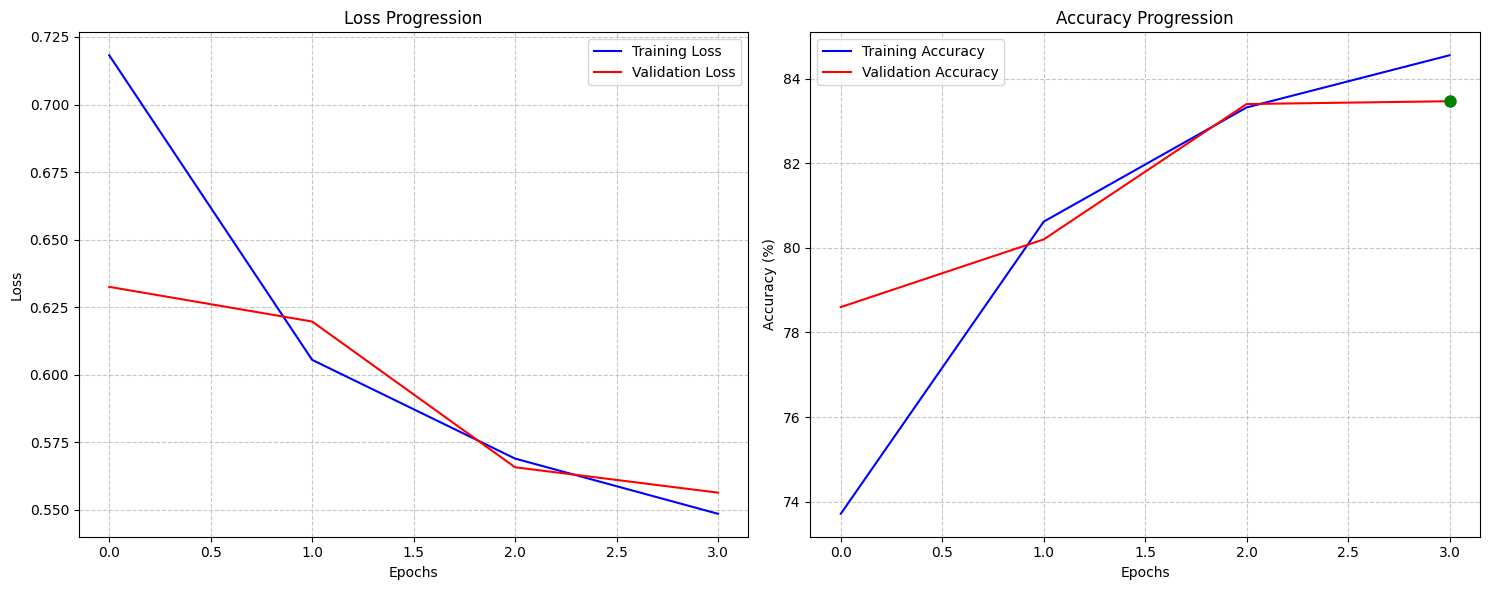

 Visualizations complete!


In [8]:

import matplotlib.pyplot as plt
print("\n Generating training performance visualizations...")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss graph
ax1.plot(history['train_loss'], 'b-', label='Training Loss')
ax1.plot(history['val_loss'], 'r-', label='Validation Loss')
ax1.set_title('Loss Progression')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Accuracy graph
ax2.plot(history['train_acc'], 'b-', label='Training Accuracy')
ax2.plot(history['val_acc'], 'r-', label='Validation Accuracy')
ax2.set_title('Accuracy Progression')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

# Mark best validation accuracy point
best_idx = best_ep - 1  # epoch index starts at 0
ax2.plot(best_idx, history['val_acc'][best_idx], 'go', markersize=8,
         label=f'Best Val: {best_acc:.1f}%')


plt.tight_layout()
plt.show()
print(" Visualizations complete!")
# ====================================================================

In [9]:
# --- CELL 3.2 : PERFORMANCE REPORTING ---------------------------------------
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    for x, y in loader:
        x = x.to(device)
        preds = model(x).argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(y)
    return torch.cat(all_preds), torch.cat(all_labels)

preds, labels = get_preds(model, val_loader)
cm = confusion_matrix(labels, preds, labels=[0,1,2])
print("\nCONFUSION MATRIX (rows=true, cols=pred):\n", cm)
print("\nClassification report:")
print(classification_report(labels, preds, target_names=SELECTED, digits=3))
print(f"Final Val Acc: {best_acc:.2f}%")


CONFUSION MATRIX (rows=true, cols=pred):
 [[963  29   8]
 [ 38 746 216]
 [ 21 184 795]]

Classification report:
              precision    recall  f1-score   support

    airplane      0.942     0.963     0.953      1000
         cat      0.778     0.746     0.762      1000
         dog      0.780     0.795     0.788      1000

    accuracy                          0.835      3000
   macro avg      0.833     0.835     0.834      3000
weighted avg      0.833     0.835     0.834      3000

Final Val Acc: 83.47%


# Final discussion


No Overfitting Detected
The model shows excellent generalization with only 1.1% gap between training (84.6%) and validation (83.5%) accuracy. Both loss curves track closely together, indicating proper regularization from weight decay and label smoothing.

Model is Underfitting
Both training and validation curves are still improving at epoch 4 without any signs of plateauing. The loss is still decreasing and accuracy is still climbing, meaning the model stopped training too early and has capacity to learn more.

Final Accuracy Performance
Achieved 83.47% validation accuracy in only 4 epochs. Airplane classification is excellent (96.3%), but cat (74.6%) and dog (79.5%) classes show significant confusion with each other, accounting for 80% of all misclassifications.

Training Curves Assessment
The loss and accuracy curves are smooth without oscillations, showing stable training. Training and validation metrics move together closely, which is ideal. However, the upward trajectory at epoch 4 indicates premature stopping.

Main Problem: Cat-Dog Confusion
216 cats were misclassified as dogs and 184 dogs as cats. This represents 400 out of 496 total errors. The model struggles to distinguish between these visually similar classes.

Recommended Next Steps
Train for 10-12 epochs instead of 4 to reach the model's full potential (expected: 86-88% accuracy). Add stronger data augmentation like color jitter and random rotation to help distinguish cats from dogs. Consider fine-tuning more ResNet layers beyond just the final classifier.

Expected Improvement
With extended training alone, validation accuracy should reach 86-87%. Adding enhanced augmentation and fine-tuning more layers could push performance to 88-90%, with cat and dog recall improving to 82-87% range.